## Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm


In [ ]:
# Random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## Creating a custom dataset class

In [ ]:
class DuckChickenDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        label = 1 if self.dataframe.iloc[idx]['label'] == 'duck' else 0  # duck: 1, chicken: 0

        if self.transform:
            image = self.transform(image)

        return image, label

## Setting up Data

- Iterates through all subfolders of a given folder path and creates a pandas DataFrame for each subfolder with image paths and labels.

In [ ]:
def create_image_dataframes(folder_path, label):
    """
    Parameters:
    -----------
    folder_path : str
        Path to the main folder containing subfolders with images
    label : str
        Label to assign to all images

    Returns:
    --------
    dict
        Dictionary with subfolder names as keys and pandas DataFrames as values
    """
    # empty dictionary to store DataFrames
    dataframes = {}

    # Check if the folder exists
    if not os.path.exists(folder_path) or not os.path.isdir(folder_path):
        raise ValueError(f"The folder path '{folder_path}' does not exist or is not a directory")

    # Get all subfolders
    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

    # For each subfolder, create a DataFrame with image paths and label
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)

        # Get all image files in the subfolder
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp']
        image_files = []

        for root, _, files in os.walk(subfolder_path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    image_files.append(os.path.join(root, file))

        # Create a DataFrame if there are any image files
        if image_files:
            df = pd.DataFrame({
                'image_path': image_files,
                'label': [label] * len(image_files)
            })

            # Add the DataFrame to the dictionary with subfolder name as key
            dataframes[subfolder] = df

    return dataframes

## Transforming the Data

In [ ]:
def get_transforms():
    """
    Create and return data transformations for training and evaluation
    """
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    eval_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return train_transforms, eval_transforms

## Preparing Data for Training and Validation 

In [ ]:
def prepare_data(duck_folder_path, chicken_folder_path):
    """
    Prepare datasets and dataloaders from the folder paths
    """
    # Create dataframes for ducks and chickens using the pre-existing split
    duck_dfs = create_image_dataframes(duck_folder_path, 'duck')
    chicken_dfs = create_image_dataframes(chicken_folder_path, 'chicken')

    # Combine duck and chicken dataframes for each split
    split_dfs = {}
    for split in ['train', 'test', 'val']:
        if split in duck_dfs and split in chicken_dfs:
            split_dfs[split] = pd.concat([duck_dfs[split], chicken_dfs[split]], ignore_index=True)
            print(f"{split} set: {len(split_dfs[split])} images")

    # Get transformations
    train_transforms, eval_transforms = get_transforms()

    # Create datasets and dataloaders for each split
    datasets = {}
    dataloaders = {}

    for split in split_dfs.keys():
        if split == 'train':
            datasets[split] = DuckChickenDataset(split_dfs[split], transform=train_transforms)
        else:
            datasets[split] = DuckChickenDataset(split_dfs[split], transform=eval_transforms)

        dataloaders[split] = DataLoader(
            datasets[split],
            batch_size=32,
            shuffle=(split == 'train'),
            num_workers=2
        )

    return datasets, dataloaders

## Creating the Model

In [ ]:
def create_model():
    """
    Create and return a fine-tunable ResNet-50 model
    """
    # Load pre-trained ResNet-50 model
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    # Modify the final fully connected layer for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)  # 2 classes: duck and chicken

    # Move model to device
    model = model.to(device)

    return model


def train_epoch(model, dataloaders, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    return running_loss, running_corrects

## Validating the Model

In [ ]:
def validate(model, dataloaders, criterion, split='val'):
    """
    Validate or test the model
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders[split]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    return running_loss, running_corrects

## Training the Model

In [ ]:
def train_model(model, datasets, dataloaders, num_epochs=10):
    """
    Train the model for specified number of epochs
    """
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3) #, verbose=True)

    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        running_loss, running_corrects = train_epoch(model, dataloaders, criterion, optimizer)

        epoch_loss = running_loss / len(datasets['train'])
        epoch_acc = running_corrects.double() / len(datasets['train'])

        # Store metrics for plotting
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        val_running_loss, val_running_corrects = validate(model, dataloaders, criterion)

        val_epoch_loss = val_running_loss / len(datasets['val'])
        val_epoch_acc = val_running_corrects.double() / len(datasets['val'])

        # Store metrics for plotting
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc.item())

        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

        # Update scheduler
        scheduler.step(val_epoch_loss)

        # Save the best model
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), 'best_duck_chicken_model.pth')
            print('Saved model with improved validation loss')

        print()

    return model, (train_losses, val_losses, train_accs, val_accs)

## Plotting the Training Curves

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    """
    Plot training and validation loss and accuracy curves
    """
    epochs = range(1, len(train_losses) + 1)

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

## Evaluating the Model

In [ ]:
def evaluate_model(model, datasets, dataloaders, target_names=['chicken', 'duck']):
    """
    Evaluate the model on the test set and generate reports
    """
    # Load the best model for test evaluation
    model.load_state_dict(torch.load('best_duck_chicken_model.pth'))
    model.eval()

    # Evaluate on test set
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test']):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=target_names)
    print("\nClassification Report:")
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

    return report, cm

## Preparing the data and Training the Model

In [ ]:
# Prepare data
duck_folder_path = r"/content/drive/MyDrive/CMI Course work/Sem 4/AML/Assignment 5/chickens_img"  # Contains train, test, val subfolders
chicken_folder_path = r"/content/drive/MyDrive/CMI Course work/Sem 4/AML/Assignment 5/duck_img" # Contains train, test, val subfolders
datasets, dataloaders = prepare_data(duck_folder_path, chicken_folder_path)


train set: 1385 images
test set: 699 images
val set: 256 images


In [ ]:
# Create model
model = create_model()

# Train model
model, metrics = train_model(model, datasets, dataloaders, num_epochs=10)
train_losses, val_losses, train_accs, val_accs = metrics

Epoch 1/10
----------


100%|██████████| 44/44 [00:20<00:00,  2.17it/s]


Train Loss: 0.2184 Acc: 0.9090


100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Val Loss: 0.0262 Acc: 0.9883
Saved model with improved validation loss

Epoch 2/10
----------


100%|██████████| 44/44 [00:24<00:00,  1.79it/s]


Train Loss: 0.1112 Acc: 0.9552


100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Val Loss: 0.0332 Acc: 0.9883

Epoch 3/10
----------


100%|██████████| 44/44 [00:18<00:00,  2.41it/s]


Train Loss: 0.1104 Acc: 0.9523


100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


Val Loss: 0.0254 Acc: 0.9922
Saved model with improved validation loss

Epoch 4/10
----------


100%|██████████| 44/44 [00:18<00:00,  2.32it/s]


Train Loss: 0.1242 Acc: 0.9516


100%|██████████| 8/8 [00:01<00:00,  4.65it/s]


Val Loss: 0.0298 Acc: 0.9844

Epoch 5/10
----------


100%|██████████| 44/44 [00:27<00:00,  1.60it/s]


Train Loss: 0.1232 Acc: 0.9596


100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Val Loss: 0.0202 Acc: 0.9961
Saved model with improved validation loss

Epoch 6/10
----------


100%|██████████| 44/44 [00:18<00:00,  2.35it/s]


Train Loss: 0.0860 Acc: 0.9632


100%|██████████| 8/8 [00:01<00:00,  4.25it/s]


Val Loss: 0.0250 Acc: 0.9922

Epoch 7/10
----------


100%|██████████| 44/44 [00:18<00:00,  2.33it/s]


Train Loss: 0.0835 Acc: 0.9682


100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Val Loss: 0.0242 Acc: 0.9922

Epoch 8/10
----------


100%|██████████| 44/44 [00:18<00:00,  2.40it/s]


Train Loss: 0.0768 Acc: 0.9682


100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Val Loss: 0.0114 Acc: 0.9961
Saved model with improved validation loss

Epoch 9/10
----------


100%|██████████| 44/44 [00:17<00:00,  2.51it/s]


Train Loss: 0.0890 Acc: 0.9646


100%|██████████| 8/8 [00:01<00:00,  4.16it/s]


Val Loss: 0.0166 Acc: 0.9883

Epoch 10/10
----------


100%|██████████| 44/44 [00:18<00:00,  2.33it/s]


Train Loss: 0.1044 Acc: 0.9581


100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Val Loss: 0.0111 Acc: 0.9961
Saved model with improved validation loss



## Plotting Training Curves

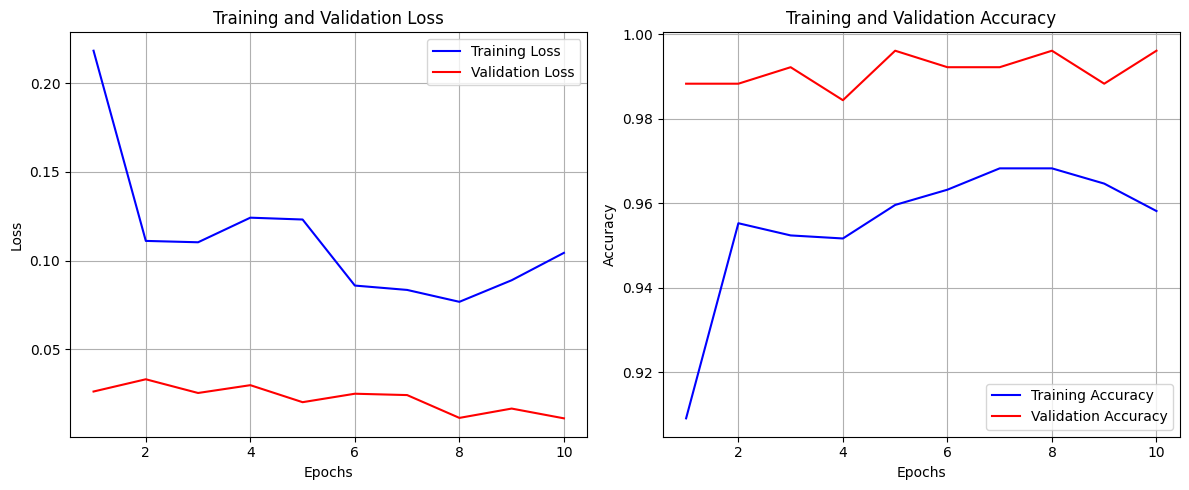

In [ ]:
# Plot training curves
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

## Evaluating the Model

100%|██████████| 22/22 [00:03<00:00,  6.53it/s]



Classification Report:
              precision    recall  f1-score   support

     chicken       0.98      1.00      0.99       310
        duck       1.00      0.99      0.99       389

    accuracy                           0.99       699
   macro avg       0.99      0.99      0.99       699
weighted avg       0.99      0.99      0.99       699


Confusion Matrix:
[[309   1]
 [  5 384]]


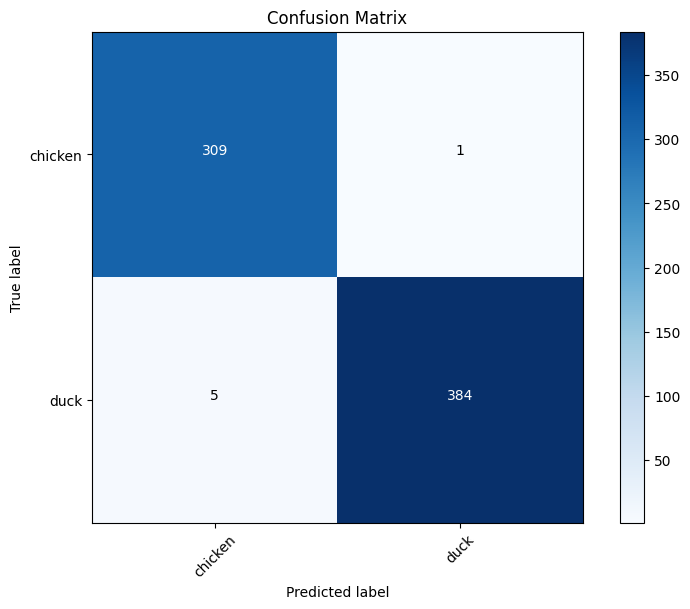

In [ ]:
# Evaluate model
report, confusion_mat = evaluate_model(model, datasets, dataloaders)